# <ins>Groupproject Python Team D</ins>

## <ins>Predict the total number of Washington D.C. bicycle users on an hourly basis</ins>


Task description:
-	Training data: whole 2011 and first 3 quarters of 2012.
-	Test data: 4th quarter of 2012.  Do not use it to fit your models!
-	Target: total number of users (cnt)
-	Error metric: R2 score (scikit-learn's default for regression).
-	Features to use: at least the ones present in the data (except for cnt, casual, and registered).
-	Groups: default groups for this term. You can split work as you consider best, but make sure each and every member is able to explain details on what was done throughout the project, even not their part.

In [1]:
# Import of all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Loading and investigating of the data
data = pd.read_csv('hour.csv', index_col = ['instant'],parse_dates = ['dteday'])
data.head(10)

,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0000,3,13,16
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,8,32,40
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,5,27,32
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,3,10,13
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,0,1,1
6,2011-01-01,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01,6,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,2,0,2
8,2011-01-01,7,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,0.2576,0.86,0.0000,1,2,3
9,2011-01-01,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,1,7,8


In [ ]:
# Checking for monotonicity
data.index.is_monotonic_increasing

## <ins>Explanatory Data Analysis (EDA)</ins>

These are the poins we will focus on
- Ensuring data quality (correctness, consistency, missing values, outliers...).
- Plotting clear and meaningful figures.
- Giving insights on what seems relevant for prediction and what does not.

And additionally we will focus on these points:

- Studying the influence of combinations of features (not just individual features).
- Checking possibly redundant variables via correlations.

In [ ]:
# Creation of the report for our data
from pandas_profiling import ProfileReport
report = ProfileReport(data, minimal=False)
report

Given the pandas profiling report we could figure out the following:
- We have 11 variables in the dataset. However we will disregard the cariables *cnt, casual and registered*.
- The following feature values are normalized in the dataset: *temp*, *atemp*, *hum* and *windspeed*.
- We are dealing with **17379** dataset observations.
- We have **499** missing values in total and split as follows:
    - **100** missing values for *weathersit*.
    - **99** missing values for *temp*.
    - **100** missing values for *atemp*.
    - **100** missing values for *hum*.
    - **100** missing values for *windspeed*.
- Out of these features me managed to identify that *atemp* is **highly correlated** with *temp* (we will exclude one of the features when running the ML algorithm).
- *dteday* is uniformly distributed and correctly parsed (this was confirmed by running the monotonic increase).
- We have **9 numerical, 1 datetime and 1 categorical** variables (the categorical variable will be transformed into numbers ranging from 1-4).

Before processing the data, we will project all of the variables to try to find the relationship with the cycling activity.

In [ ]:
#my_set = set(my_list)
#my_new_list = list(my_set)
#print("List of unique numbers : ",my_new_list)

In [ ]:
sns.pairplot(data,kind="reg", plot_kws={'line_kws':{'color':'red'},'scatter_kws':dict(alpha=0.1,color = 'orange')},
            corner = True)

In [ ]:
# Create Fig and gridspec
s = sns.jointplot(x="temp", y="cnt", data=data,
                  kind="reg", truncate=False,joint_kws={'line_kws':{'color':'red'},'scatter_kws':dict(alpha=0.1)},
                  xlim=(0,1),
                  color="orange", height=7)


> As shown in the graph, we can see a positive correlation between the number of bike usage and temperature. This is is obvious as people are more likely to bike outdoors when the temperature is high, and less likely to bike outdoor when the temperature drops.  When we have extreme cases of cold or hot weather, the bike usage drops again.

In [ ]:
# Create Fig and gridspec
s = sns.jointplot(x="hum", y="cnt", data=data,
                  kind="reg", truncate=False,joint_kws={'line_kws':{'color':'red'},'scatter_kws':dict(alpha=0.1)},
                  xlim=(0,1),
                  color="orange", height=7)

> From the scatter plot we can spot a negative correlation between humidity and the cycling activity rate. Very High Humidity can be correlated with higher chances of rain, hence the decline in cycling activity. For this plot we can assume that weather condition affects the cycling activity. To confirm this hypothesis, we will visualize in the following chart the "weathersit" feature.

In [ ]:
# Create Fig and gridspec
plt.figure(figsize=(8,10))
sns.countplot(y="weathersit", data=data,orient="h")

> This graph confirms our hypothesis, it shows that there are more clear sunny days in the data set than rainy or overcast days

In [ ]:
# Create Fig and gridspec
s = sns.jointplot(x="windspeed", y="cnt", data=data,
                  kind="reg", truncate=False,joint_kws={'line_kws':{'color':'red'},'scatter_kws':dict(alpha=0.1)},
                  xlim=(0,1),
                  color="orange", height=7)

> The windspeed graphs show a weak correlation between the feature and bike usage rate. This feature doesn't provide powerful insights into the usage rate. We can highlight that with severe wind speed, (outliers) the rate drops as expected and seen in the histogram above.

In [ ]:
# Create Fig and gridspec
data_new = data.copy()
data_new = data_new.drop(["registered","casual"], axis=1)


sns.heatmap(data_new.corr(), annot = True,  cbar_kws= {'orientation': 'horizontal'} )

> Based on the analysis above we can see that clearly as stated before the temp and atemp variable are highly correlated and therefore we will exclude the atemp variable. Also all of the other variables are not correlated to eeach other and therefore independent.

##### ***Data engineering***

These are the points we will focus on

- Discussion on missing values and outliers
- Treatment of text and date features
- Generation of extra datetime related features (month, day, date of week, season, T/F holiday, time of day and workday)



In [3]:
#Extracting the month, day and day of week from the date

df = data.rename(columns={'dteday': 'dateday'})

from operator import attrgetter


df['dateday'] = pd.to_datetime(df['dateday'])

# list attributes
dt_attrs = [ 'month', 'day', 'dayofweek']

# extract attributes
attributes = df['dateday'].apply(attrgetter(*dt_attrs))

# add attributes to dataframe
df[dt_attrs] = pd.DataFrame(attributes.values.tolist())

#bug
df['day']= df['day'].fillna(31.0).astype(int)
df['month']= df['month'].fillna(12.0)
df['dayofweek']= df['dayofweek'].fillna(0.0).astype(int)


In [4]:
#Extracting Calender holidays from date

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2011-01-01', end='2012-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df['holiday'] = df['dateday'].isin(holidays)

#df['workday'] = df.where( (df['holiday']==False) & (df['dayofweek'] < 5) , True, False)

conditions = [
    (df['holiday'] == False) & (df['dayofweek'] < 5)]

df['workday'] = np.select(conditions, 'T', 'F')

In [5]:
# Replacing of the days
df['dayofweek'].replace({0.0: 'Monday',
                      1.0: 'Tuesday',
                      2.0: 'Wednesday',
                      3.0: 'Thursday',
                      4.0: 'Friday',
                      5.0: 'Saturday',
                      6.0: 'Sunday'}, inplace=True)
# Replacing  of the month
df['month'].replace({1.0: 'January',
                      2.0: 'February',
                      3.0: 'March',
                      4.0: 'April',
                      5.0: 'May',
                      6.0: 'June',
                      7.0: 'July',
                      8.0: 'August',
                      9.0: 'September',
                      10.0: 'October',
                      11.0: 'November',
                      12.0: 'December' }, inplace=True)


In [6]:
#Extracting season from the dates
date = df.dateday.dt.month*100 + df.dateday.dt.day
df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                       labels=['winter','spring','summer','autumn','winter '])
                  .str.strip()
               )

In [7]:
#Extarcting the time of the day form the hour column
df['period'] = (df['hr'] % 24 + 4) // 4
df['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [ ]:
df.head(10)

In [8]:
#Replacing missing value with the mean of the aggreate in the levels of dateday and period

df_alt = df.copy()
df_alt.loc[df_alt["temp"].isnull(), "temp"] = df_alt.groupby(["dateday", "period"])["temp"].transform("median")
df_alt.loc[df_alt["atemp"].isnull(), "atemp"] = df_alt.groupby(["dateday", "period"])["atemp"].transform("median")
df_alt.loc[df_alt["hum"].isnull(), "hum"] = df_alt.groupby(["dateday", "period"])["hum"].transform("median")
df_alt.loc[df_alt["windspeed"].isnull(), "windspeed"] = df_alt.groupby(["dateday", "period"])["windspeed"].transform("median")



print("check for temp:",(df_alt["temp"] == df["temp"]).all())
print("check for atemp:",(df_alt["atemp"] == df["atemp"]).all())
print("check for hum:",(df_alt["hum"] == df["hum"]).all())
print("check for windspeed:",(df_alt["windspeed"] == df["windspeed"]).all())

check for temp: False
check for atemp: False
check for hum: False
check for windspeed: False


In [9]:
#df_alt['weathersit'] = df_alt['weathersit'].fillna(df_alt.groupby(["dateday", "period"])['weathersit'].agg(pd.Series.mode))

#Replace weathersit with the most frequent weather sit in that period
mode_weathersit_period_groups = df_alt.groupby(["dateday", "period"])['weathersit'].agg(pd.Series.mode)
mode_weathersit_period_groups

# We do a .merge to "expand" our groups to fit the original dataset
mode_weathersit_period_groups.name = "Inferredsit"  # For clarity
mode_weathersit_period = (
    df_alt[["dateday", "period"]]  # Select only the columns we are interested in
    .merge(
        mode_weathersit_period_groups,
        left_on=["dateday", "period"],
        right_index=True  # mode_weathersit_period_groups is indexed by dateday and period already
    ).sort_index()  # For better display
)
mode_weathersit_period.head()

df_alt.loc[df_alt["weathersit"].isnull(), "weathersit"] = mode_weathersit_period["Inferredsit"]
df_alt["weathersit"] = df_alt['weathersit'].astype('str')

In [10]:
#Checking if matrices are the same 
rows_original_age = ~df["weathersit"].isnull()
(df_alt.loc[rows_original_age, "weathersit"] == df.loc[rows_original_age, "weathersit"]).all()


True

In [ ]:
# import the seaborn module
import seaborn as sns
# import the matplotlib module
import matplotlib.pyplot as plt
# setting the plot size for all plots
sns.set(rc={'figure.figsize':(16.7,13.27)})

# Creation of all violin plots
sns.violinplot(x="season",y="cnt", hue="workday", data=df, palette= "Set2", split=True);
plt.show()

sns.violinplot(x="period",y="cnt", hue="workday", data=df, palette= "Set3", split=True);
plt.show()

sns.violinplot(x="hr",y="cnt", hue="workday", data=df, palette= "Set2", split=True);
plt.show()

In [ ]:
df_alt.info()

In [10]:
from sklearn.preprocessing import OneHotEncoder

#Making columns categorical

df_alt["weathersit"] = df_alt['weathersit'].astype('category')
df_alt["month"] = df_alt['month'].astype('category')
df_alt["dayofweek"] = df_alt['dayofweek'].astype('category')
df_alt["holiday"] = df_alt['holiday'].astype('category')
df_alt["workday"] = df_alt['workday'].astype('category')
df_alt["season"] = df_alt['season'].astype('category')
df_alt["period"] = df_alt['period'].astype('category')
df_alt["day"] = df_alt['day'].astype('category')

df_alt.head(30)

,dateday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,month,day,dayofweek,holiday,workday,season,period
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0000,3,13,16,January,1,Saturday,False,F,winter,Late Night
2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,8,32,40,January,1,Saturday,False,F,winter,Late Night
3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,5,27,32,January,1,Saturday,False,F,winter,Late Night
4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,3,10,13,January,1,Saturday,False,F,winter,Late Night
5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,0,1,1,January,1,Saturday,False,F,winter,Early Morning
6,2011-01-01,5,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.24,0.2576,0.75,0.0896,0,1,1,January,1,Saturday,False,F,winter,Early Morning
7,2011-01-01,6,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0000,2,0,2,January,1,Saturday,False,F,winter,Early Morning
8,2011-01-01,7,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.20,0.2576,0.86,0.0000,1,2,3,January,1,Saturday,False,F,winter,Early Morning
9,2011-01-01,8,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0000,1,7,8,January,1,Saturday,False,F,winter,Morning


In [ ]:
# Pandas profiling for changed dataset
from pandas_profiling import ProfileReport
report = ProfileReport(df_alt, minimal=False)
report

> As we can see from the above correlation table that hr is highly correlated to period and month is highly correlated to season, since season and periods accounts for a better cyclic trend in the data we drop month and hour to avoid multicollinearity

In [11]:
# Setting the dataframe new
ads = df_alt.reset_index(drop = True).set_index('dateday')
ads = ads.drop(['hr','atemp','casual','registered','month','day'],axis=1)
ads

,weathersit,temp,hum,windspeed,cnt,dayofweek,holiday,workday,season,period
dateday,,,,,,,,,,
2011-01-01,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.81,0.0000,16,Saturday,False,F,winter,Late Night
2011-01-01,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.80,0.0000,40,Saturday,False,F,winter,Late Night
2011-01-01,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.80,0.0000,32,Saturday,False,F,winter,Late Night
2011-01-01,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.75,0.0000,13,Saturday,False,F,winter,Late Night
2011-01-01,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.75,0.0000,1,Saturday,False,F,winter,Early Morning
...,...,...,...,...,...,...,...,...,...,...
2012-12-31,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.60,0.1642,119,Monday,False,T,winter,Evening
2012-12-31,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.60,0.1642,89,Monday,False,T,winter,Night
2012-12-31,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.60,0.1642,90,Monday,False,T,winter,Night


In [12]:
# Splitting the dataset into train and test
train = ads.loc[:'2012-09-30'].reset_index(drop = True)
test = ads.loc['2012-10-01':].reset_index(drop = True)

# Splitting each dataset into explanatory and response variables
X_train = train.iloc[:,:-1] # exlanatory variables for the training
X_train= X_train.drop('cnt',axis=1)
y_train = train.loc[:,'cnt'] # response variables for the training

X_test = test.iloc[:,:-1] # exlanatory variables for the test
X_test= X_test.drop('cnt',axis=1)
y_test = test.loc[:,'cnt'] # response variables for the test

In [25]:
#!pip3 install pycaret
#conda install -c conda-forge pycaret
from pycaret import regression

# setup the environment 
regression_setup = regression.setup(data= train,
                                    target='cnt', 
                                    train_size = .7,
                                    use_gpu = True,
                                    feature_selection_threshold = 0.6,
                                    n_jobs = 10)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,5994
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(15211, 10)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,6
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [15]:
# Modeling a linear regression
regression_kr = regression.create_model('lr',
                                        fold = 5, 
                                        method = 'Boosting', 
                                        ensemble = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,417946813499.5798,372067417708405330714558464.0000,19289049165482.6094,-12113014049622563225600.0000,1.3465,2548456182.7792
1,100.0847,16828.3188,129.7240,0.4862,1.1297,2.9291
2,103.9609,17129.0444,130.8780,0.4490,1.1698,3.3636
3,122.8661,22627.3445,150.4239,0.2811,1.3194,4.4372
4,88.5183,14460.1025,120.2502,0.5274,1.1204,2.8156
Mean,83589362783.0020,74413483541681062706937856.0000,3857809833202.7778,-2422602809924512645120.0000,1.2172,509691239.2649
SD,167178725358.2890,148826967083362125413875712.0000,7715619666139.9170,4845205619849026338816.0000,0.0964,1019382471.7571


In [16]:
# Modeling a kernel ridge regression
regression_kr = regression.create_model('kr',
                                        fold = 5, 
                                        method = 'Boosting', 
                                        ensemble = True,
                                        kernel = 'rbf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,78.7897,11390.9941,106.7286,0.6292,1.0030,2.4808
1,83.0016,12904.7327,113.5990,0.6060,0.9927,2.4569
2,79.2932,11692.6282,108.1325,0.6239,0.9725,2.2088
3,80.1730,12138.6032,110.1753,0.6144,0.9821,2.2661
4,79.4644,12080.7012,109.9122,0.6052,1.0230,2.5187
Mean,80.1444,12041.5319,109.7095,0.6157,0.9947,2.3862
SD,1.4957,510.0992,2.3134,0.0095,0.0175,0.1244


In [26]:
# Modeling of random forest
regression_rf = regression.create_model('rf',
                                        fold = 7, 
                                        method = 'Boosting',
                                        n_estimators = 300,
                                        min_samples_leaf = 8,
                                        max_depth = 50,
                                        ensemble = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,74.6510,11474.8325,107.1206,0.6551,0.8735,2.0928
1,70.0090,9941.4091,99.7066,0.6833,0.9087,2.3198
2,73.2464,10968.0327,104.7284,0.6688,0.8876,2.0810
3,74.4037,11548.5616,107.4642,0.6649,0.8512,1.8403
4,71.9641,11007.8634,104.9184,0.6655,0.8199,1.7626
5,70.1798,10206.4370,101.0269,0.6704,0.8104,1.5249
6,71.7335,10232.1189,101.1539,0.6587,0.8697,2.0285
Mean,72.3125,10768.4650,103.7313,0.6667,0.8601,1.9500
SD,1.7331,596.6823,2.8780,0.0084,0.0329,0.2415


In [29]:
# Modelling xgboost
regression_xgb = regression.create_model('xgboost',
                                         max_depth = 6,
                                         booster = "gbtree",
                                         nthread = 10,
                                         max_leaf_nodes = 8,
                                         scale_pos_weight = 1,
                                         colsample_bytree = 0.8,
                                         min_child_weight = 4,
                                         n_estimators=300,
                                         eta = 0.2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,72.7919,11009.7625,104.9274,0.6511,0.8891,1.7459
1,74.0668,12107.4982,110.0341,0.6546,0.9666,2.2024
2,68.9099,9452.0735,97.2218,0.6852,0.9033,2.1895
3,71.2971,10514.7836,102.5416,0.6805,0.9419,2.0028
4,75.8438,12628.2251,112.3754,0.6290,0.9274,1.8725
5,73.4024,11552.7004,107.4835,0.6763,0.8812,1.5496
6,71.5856,11465.3431,107.0763,0.6340,0.8763,1.7325
7,72.7998,10998.9122,104.8757,0.6513,0.8921,1.5670
8,69.5765,10387.8725,101.9209,0.6732,0.8172,1.4077
9,70.2282,10235.0902,101.1686,0.6459,0.9256,2.0936


In [116]:
# Modelling omp
regression_omp = regression.create_model('omp')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,109.7203,21044.8134,145.0683,0.3330,1.2881,4.2433
1,107.5617,21259.8419,145.8076,0.3935,1.3750,4.9903
2,106.8670,19872.2950,140.9691,0.3381,1.3413,4.7103
3,108.2099,20518.9639,143.2444,0.3765,1.3797,4.9617
4,109.3659,21491.5471,146.6000,0.3686,1.3390,4.6722
5,108.3053,21996.0457,148.3106,0.3837,1.2759,3.7666
6,108.7054,20776.9832,144.1422,0.3368,1.3586,4.6789
7,103.1320,18932.3516,137.5949,0.3997,1.2546,3.6943
8,104.4242,19390.1817,139.2486,0.3900,1.2621,3.9596
9,100.3378,17995.2997,134.1466,0.3775,1.3294,4.4928


In [15]:
# Modeling mlp
regression_mlp = regression.create_model('mlp',
                                         alpha = 1,
                                         hidden_layer_sizes=(40, 120, 50, 10),
                                         beta_1 = 0.7,
                                         warm_start = True,
                                         max_iter = 500,
                                         activation = 'relu',
                                         solver='adam') #'lbfgs'

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,69.1410,10132.4862,100.6603,0.7008,0.8101,1.4953
1,58.7673,7721.2866,87.8709,0.7481,0.7439,1.3955
2,62.0118,8913.6792,94.4123,0.7185,0.7495,1.2227
3,62.7147,9547.0881,97.7092,0.7155,0.7082,0.9988
4,60.5313,8786.7840,93.7378,0.7042,0.7745,1.3474
5,57.7075,8037.3770,89.6514,0.7540,0.7610,1.2680
6,60.8882,8248.5884,90.8217,0.7354,0.7593,1.3044
7,59.0701,8129.9288,90.1661,0.7389,0.7111,1.1327
8,63.0059,8258.5089,90.8763,0.7451,0.7502,1.2558
9,59.1596,7723.5506,87.8837,0.7446,0.8105,1.6479


In [ ]:
# Tuning of mlp
regression_tuned_mlp = regression.tune_model(regression_mlp,
                                             choose_better=True,
                                             custom_grid = {'alpha' : [1,0.1, 0.01, 0.001],
                                                            'beta_1' : [0.7,0.8,0.9]})                                            

In [20]:
# Model comparison
regression.compare_models(include = ['lr','lasso','ridge','kr','dt','rf','xgboost','mlp'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extreme Gradient Boosting,68.3130,10223.3450,101.0688,0.6733,0.8690,1.6566,0.4555
1,Random Forest,67.6815,10358.0253,101.7283,0.6690,0.8243,1.5673,0.5706
2,Multi Level Perceptron,73.0697,11192.4258,105.7440,0.6427,0.9008,1.8354,7.6218
3,Linear Regression,88.0528,14584.0316,120.7289,0.5344,1.0811,2.5062,0.0078
4,Ridge Regression,88.0329,14582.1098,120.7211,0.5344,1.0808,2.4987,0.0051
5,Kernel Ridge,88.0334,14582.0566,120.7209,0.5344,1.0808,2.4991,6.2381
6,Lasso Regression,87.8868,14676.7894,121.1134,0.5314,1.0723,2.4467,0.0080
7,Decision Tree,87.3781,18680.8778,136.5907,0.4032,0.9999,1.6682,0.0519


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1,
             objective='reg:squarederror', random_state=693, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [117]:
# Blending the mlp together with omp
blender = regression.blend_models(estimator_list=[regression_mlp, regression_omp])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,82.6693,13092.3029,114.4216,0.5850,1.0675,2.8146
1,82.4351,13242.1923,115.0747,0.6222,1.1426,3.3562
2,78.6035,11486.5954,107.1755,0.6174,1.1013,3.1021
3,81.8453,12917.3516,113.6545,0.6075,1.1393,3.1141
4,86.2961,14301.9780,119.5909,0.5798,1.1204,3.1227
5,83.7587,13792.6146,117.4420,0.6136,1.0561,2.5081
6,83.3693,13218.7996,114.9730,0.5780,1.1185,3.0868
7,79.3467,11932.1190,109.2342,0.6217,1.0441,2.4682
8,78.6581,11742.1784,108.3613,0.6306,1.0357,2.5217
9,76.9164,11168.2722,105.6800,0.6136,1.1072,3.0698


In [ ]:
# Tuning of random forest
regression_tuned_rf = regression.tune_model(regression_rf,
                                            n_iter = 50,
                                            fold = 3)

In [28]:
# Display of the model (takes like 4h to generate)
regression.evaluate_model(regression_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
#Plotting models (same as above)
#regression.evaluate_model(regression_tuned_mlp)

In [17]:
# Prediction for the rides
predictions = regression.predict_model(regression_mlp, data=test)

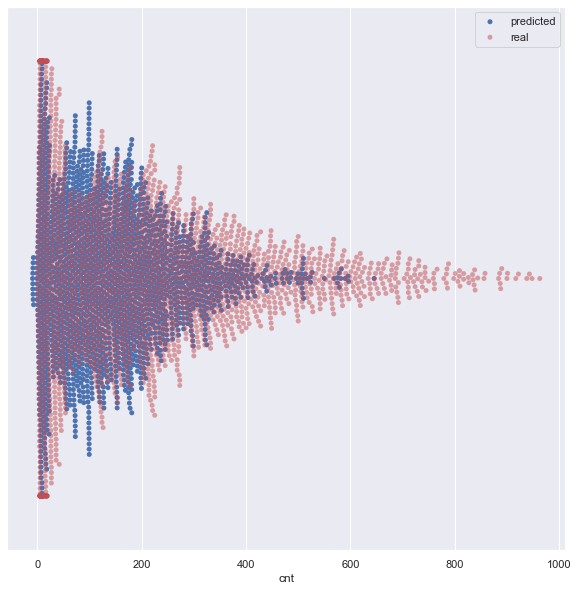

In [115]:
# Beeswarm plot of the actual vs. the predicted data
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot(predictions.Label, label = 'predicted')
sns.swarmplot(predictions.cnt,color = 'r', label = 'real', alpha = 0.5)
plt.legend()

> Given the beeswarm plot we can see that the model wouldn't do a too bad job but it needs just to be skeewed a bit. (no more time to improve it further)

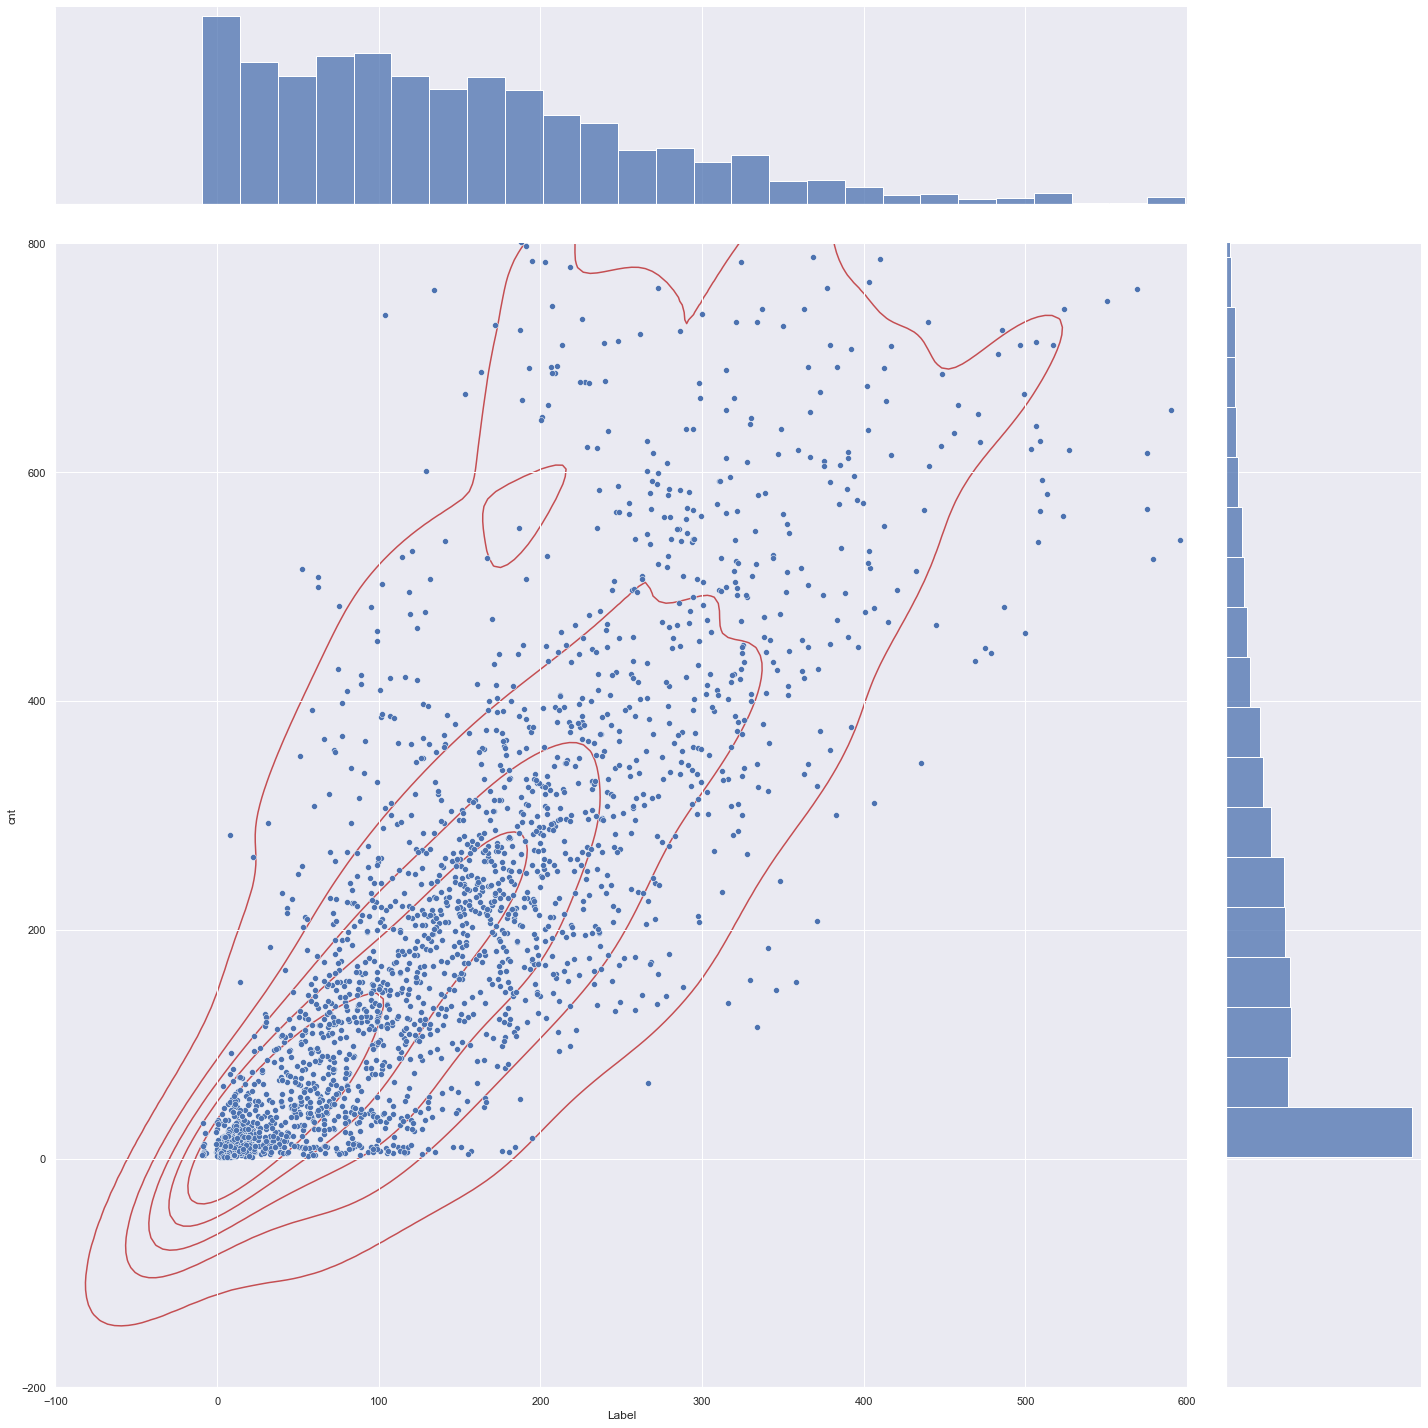

In [60]:
# Contour plot
g = sns.jointplot(x="Label",
                  y="cnt", 
                  data=predictions, 
#                  hue = 'period', 
                  height = 20,
                  xlim=(-100,600),
                  ylim=(-200,800),)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)


> We see that the smaller values are pretty well predicted, but the extrem values and the variance is quite spread.